# Model Training and Evaluation

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dotenv import load_dotenv
import os

from neo4j import GraphDatabase

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import optuna

from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Neo4j connection details

load_dotenv('../KG/db.env')

uri = os.getenv("NEO4J_URI")
user = os.getenv("NEO4J_USER")
password = os.getenv("NEO4J_PASSWORD")

# Creating a Neo4j Driver Instance
driver = GraphDatabase.driver(uri, auth=(user, password))

# Verifying Connection
try:
    driver.verify_connectivity()
except Exception as err:
    print(f"Error: {err}, type: {type(err)}")

In [3]:
# Define a function to retrieve data from the knowledge graph based on suitable cypher queries 

def retrieve_data_from_graph(query):
    
    result_data = []

    with driver.session() as session:
        result = session.run(query)

        for record in result:
            result_data.append(dict(record))
    
    return result_data

In [4]:
# Function to retrieve all the data for a particular disease

def get_data_of_disease(disease):
    
    # Retrieve data for a specific disease from the knowledge graph.

    # Parameters:
    #     disease_name (str): The name of the disease to retrieve data for.

    # Returns:
    #     disease_df (pd.DataFrame): DataFrame containing person, disease, biomarker, and protein data.
    
    disease_query = """
    MATCH (p:Person)-[s:SUFFERS_FROM]->(d:Disease)
    where d.name = '"""+ disease +"""' and s.status IN ['Positive','Negative']
    RETURN p.respondentId as Respondent_ID,
    d.name AS DiseaseName,
    s.status AS DiseaseStatus;
    """

    disease_df = pd.DataFrame(retrieve_data_from_graph(disease_query))
    disease_data = disease_df.pivot(index=['Respondent_ID'],columns='DiseaseName', values='DiseaseStatus')
    disease_data = disease_data.reset_index()
    disease_data[disease] = disease_data[disease].map({'Negative': 0, 'Positive' : 1})

    biomarker_query = """
    MATCH (p:Person)-[s:SUFFERS_FROM]->(d:Disease)
    where d.name = '"""+ disease +"""' and s.status IN ['Positive','Negative']
    MATCH (p)-[h:HAS]->(b:BloodBiomarker)
    RETURN p.respondentId as Respondent_ID,
    p.gender AS Gender,
    p.age AS Age,
    p.bmi AS BMI,
    b.name AS BiomarkerName,
    b.unit AS BiomarkerUnit,
    h.value AS BiomarkerValue;
    """

    biomarker_df = pd.DataFrame(retrieve_data_from_graph(biomarker_query))
    biomarker_df['BloodBiomarker'] = np.where(biomarker_df['BiomarkerUnit'].notnull(),
                                       biomarker_df['BiomarkerName'] + ' [' + biomarker_df['BiomarkerUnit'] + ']',
                                       biomarker_df['BiomarkerName'])
    biomarker_data = biomarker_df.pivot(index=['Respondent_ID','Gender','Age','BMI'], 
                                        columns='BloodBiomarker',
                                        values='BiomarkerValue')
    biomarker_data = biomarker_data.reset_index()
    biomarker_data['Gender'] = biomarker_data['Gender'].map({'Female': 0, 'Male' : 1})


    protein_query = """
    MATCH (p:Person)-[s:SUFFERS_FROM]->(d:Disease)
    where d.name = '"""+ disease +"""' and s.status IN ['Positive','Negative']
    MATCH (p)-[h:HAS]->(b:BloodProtein)
    RETURN p.respondentId as Respondent_ID,
    b.name AS ProteinName,
    b.unit AS ProteinUnit,
    h.value AS ProteinValue;
    """

    protein_df = pd.DataFrame(retrieve_data_from_graph(protein_query))
    protein_df['BloodProtein'] = np.where(protein_df['ProteinUnit'].notnull(),
                                       protein_df['ProteinName'] + ' [' + protein_df['ProteinUnit'] + ']',
                                       protein_df['ProteinName'])
    protein_data = protein_df.pivot(index=['Respondent_ID'], 
                                        columns='BloodProtein',
                                        values='ProteinValue')
    protein_data = protein_data.reset_index()

    disease_df = biomarker_data.merge(protein_data, on='Respondent_ID',how='inner')
    disease_df = disease_df.merge(disease_data, on='Respondent_ID',how='inner')
    
    return disease_df

# Diabetes

In [5]:
# Data for Diabetes

diabetes_df = get_data_of_disease('Diabetes')
diabetes_df

,Respondent_ID,Gender,Age,BMI,25-hydroxyvitamin D2 + D3 [nmol/L],A/G Ratio,Alpha-carotene [umol/L],Alpha-crypotoxanthin [umol/L],Alpha-tocopherol [umol/L],Basophils [%],...,Ferritin [ng/mL],Gamma Glutamyl Transferase [IU/L],Hemoglobin [g/dL],Insulin [pmol/L],LDL-Cholesterol(NIH2) [mmol/L],Lactate Dehydrogenase [IU/L],Transferrin Saturation [%],Transferrin receptor [nmol/L],Triglyceride [mmol/L],Diabetes
0,93703,0,2,17.5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,93704,1,2,15.7,74.4,NaN,NaN,NaN,NaN,0.7,...,36.60,NaN,13.1,NaN,NaN,NaN,NaN,30.6,NaN,0
2,93705,0,66,31.7,89.9,1.517241,0.138,0.071,26.006,1.0,...,28.70,21.0,11.9,NaN,NaN,174.0,28.0,39.8,NaN,0
3,93706,1,18,21.5,53.8,1.629630,0.160,0.031,16.765,0.8,...,284.00,16.0,16.3,NaN,NaN,142.0,51.0,34.0,NaN,0
4,93707,1,13,18.1,58.2,1.857143,0.009,0.044,22.756,0.5,...,49.30,9.0,14.5,NaN,NaN,177.0,21.0,34.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8888,102952,0,70,20.0,82.7,1.846154,0.235,0.077,31.347,0.6,...,135.00,18.0,13.4,26.34,1.112,168.0,39.0,29.1,0.881,1
8889,102953,1,42,35.8,49.5,1.142857,0.106,0.080,21.873,0.6,...,120.00,28.0,15.5,NaN,NaN,136.0,20.0,28.6,NaN,0
8890,102954,0,41,26.1,50.5,1.500000,0.117,0.056,26.935,1.4,...,1.99,8.0,6.4,56.94,2.793,123.0,5.0,248.0,0.553,0
8891,102955,0,14,45.6,61.9,1.205882,0.031,0.079,17.856,0.9,...,11.40,16.0,11.4,NaN,NaN,158.0,5.0,57.7,NaN,0


In [6]:
diabetes_df.shape

(8893, 91)

## Pre-processing

In [7]:
# Seperate the attributes and labels

X = diabetes_df.drop(['Respondent_ID','Diabetes'],axis=1)
y = diabetes_df['Diabetes'].copy()

In [8]:
# Splitting the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [9]:
imputer = SimpleImputer(strategy='mean')

imputer.fit(X_train)

imputer.statistics_     # contains the mean values for each attribute

array([4.94658420e-01, 3.59339331e+01, 2.66632902e+01, 6.69514656e+01,
       1.35202339e+00, 9.39828822e-02, 5.47632135e-02, 2.65182621e+01,
       7.56096753e-01, 1.96819124e-01, 1.46247362e+01, 3.32056939e+00,
       5.17312568e-02, 1.87938976e+02, 5.72086819e+00, 2.36572875e+00,
       6.82204875e+00, 2.02666800e-02, 3.58133427e+00, 4.08380899e+01,
       8.74950411e-01, 2.96303844e+00, 6.19282418e+00, 4.17317981e+00,
       3.08708316e+00, 5.76856497e+00, 4.08877754e+01, 1.63781259e+01,
       8.73197552e+01, 1.54538462e+01, 2.19882788e+00, 3.44511980e-01,
       3.41073393e+01, 3.25265641e+01, 4.47506490e+00, 3.35746563e+01,
       2.90903595e+01, 8.65968362e+01, 8.09436806e+00, 8.20218688e+00,
       1.88218522e+00, 1.26717164e+02, 8.42009284e-02, 2.80846349e+02,
       3.66912199e+00, 2.59371211e+02, 1.17680544e+02, 3.76126934e+01,
       4.09615709e+00, 4.73612722e+00, 1.37733477e+01, 1.71851328e+00,
       5.37858134e-02, 1.99033503e-02, 5.40956925e+01, 1.40336076e+02,
      

In [10]:
X_train = imputer.transform(X_train)

X_train = pd.DataFrame(X_train, columns=X.columns)

# Data with null values imputed with mean
X_train

,Gender,Age,BMI,25-hydroxyvitamin D2 + D3 [nmol/L],A/G Ratio,Alpha-carotene [umol/L],Alpha-crypotoxanthin [umol/L],Alpha-tocopherol [umol/L],Basophils [%],Beta-cryptoxanthin [umol/L],...,Direct HDL-Cholesterol [mmol/L],Ferritin [ng/mL],Gamma Glutamyl Transferase [IU/L],Hemoglobin [g/dL],Insulin [pmol/L],LDL-Cholesterol(NIH2) [mmol/L],Lactate Dehydrogenase [IU/L],Transferrin Saturation [%],Transferrin receptor [nmol/L],Triglyceride [mmol/L]
0,0.0,64.0,33.0,97.900000,1.310345,0.259000,0.087000,48.994000,0.4,1.254000,...,1.710000,99.300000,14.000000,14.4,60.840000,4.758000,160.000000,17.000000,31.400000,0.892000
1,0.0,24.0,17.2,26.200000,1.151515,0.037000,0.024000,18.483000,0.8,0.067000,...,1.660000,21.400000,19.000000,12.3,85.300426,2.805636,121.000000,21.000000,36.800000,1.213088
2,1.0,11.0,17.6,76.600000,1.352023,0.077000,0.109000,23.684000,0.4,0.355000,...,1.378027,134.844354,29.777543,15.5,85.300426,2.805636,159.609324,26.935729,40.461962,1.213088
3,1.0,39.0,27.2,54.000000,1.000000,0.009000,0.074000,89.397000,0.5,0.147000,...,0.750000,578.000000,88.000000,16.0,85.300426,2.805636,159.609324,43.000000,24.500000,1.213088
4,1.0,64.0,33.7,79.300000,1.147059,0.028000,0.043000,25.542000,0.8,0.067000,...,1.270000,72.800000,18.000000,13.6,85.300426,2.805636,147.000000,21.000000,44.500000,1.213088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7109,0.0,51.0,25.6,53.900000,1.344828,0.183000,0.052000,19.435000,0.5,0.113000,...,1.630000,109.000000,10.000000,13.8,40.380000,2.069000,136.000000,34.000000,34.800000,1.073000
7110,0.0,53.0,20.3,60.700000,1.400000,0.117000,0.116000,35.294000,1.1,1.012000,...,1.810000,186.000000,49.000000,12.8,85.300426,2.805636,136.000000,21.000000,31.400000,1.213088
7111,0.0,5.0,17.7,70.500000,1.352023,0.093983,0.054763,26.518262,0.7,0.196819,...,1.378027,18.900000,29.777543,12.6,85.300426,2.805636,159.609324,26.935729,44.600000,1.213088
7112,0.0,77.0,27.9,66.951466,1.352023,0.093983,0.054763,26.518262,0.9,0.196819,...,1.378027,134.844354,29.777543,16.3,85.300426,2.805636,159.609324,26.935729,40.461962,1.213088


In [11]:
X_test = imputer.transform(X_test)
X_test = pd.DataFrame(X_test, columns=X_train.columns)

In [12]:
y_train

7481    1
2022    0
3847    0
5980    0
1928    1
       ..
5734    0
5191    0
5390    0
860     0
7270    0
Name: Diabetes, Length: 7114, dtype: int64

In [13]:
# Scaling the data

X_train_gender = X_train.Gender
X_train = X_train.drop('Gender',axis=1)
X_test_gender = X_test.Gender
X_test = X_test.drop('Gender',axis=1)
cols = X_train.columns

scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=cols)
X_test = pd.DataFrame(X_test, columns=cols)

X_train.insert(0, "Gender", X_train_gender)
X_test.insert(0, "Gender", X_test_gender)

### Pipeline for Pre-processing

In [7]:
# We can define a function to do all the preprocessing and the splitting of data

def preprocess_and_split(df, label, impute=True, scale=True, imputer = SimpleImputer(),
                         scaler = StandardScaler(), test_size=0.2, random_state=42):
    
    # Preprocesses the input dataframe and splits it into training and testing sets.
    
    if 'Respondent_ID' in df.columns:
        X = df.drop(['Respondent_ID'], axis=1)
        X = X.drop([label], axis=1)
        
    X = df.drop([label], axis=1)
    y = df[label].copy()
    
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Separate categorical and numerical columns 
    categorical_cols = ['Gender'] 
    numeric_cols = [col for col in X.columns if col not in categorical_cols]
    
    # Preprocessing for numerical data
    numeric_transformer = Pipeline(steps=[
        ('imputer', imputer) if impute else ('imputer', 'passthrough'),
        ('scaler', scaler) if scale else ('scaler', 'passthrough')
    ])
    
    # Preprocessing for categorical data
    categorical_transformer = Pipeline(steps=[
        ('pass', 'passthrough')])
    
    # Bundle preprocessing for numerical and categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_cols),
            ('num', numeric_transformer, numeric_cols)
        ])
    
    # Preprocess data
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)
    X = preprocessor.transform(X)

    
    # Convert back to DataFrames
    X_train = pd.DataFrame(X_train, columns= categorical_cols + numeric_cols)
    X_test = pd.DataFrame(X_test, columns= categorical_cols + numeric_cols)
    X = pd.DataFrame(X, columns= categorical_cols + numeric_cols)

    return X, y, X_train, X_test, y_train, y_test

In [8]:
# Attributes and Labels

X, y, X_train, X_test, y_train, y_test = preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=SimpleImputer(strategy='mean'),
                                                              random_state=42)

In [9]:
X

,Gender,Respondent_ID,Age,BMI,25-hydroxyvitamin D2 + D3 [nmol/L],A/G Ratio,Alpha-carotene [umol/L],Alpha-crypotoxanthin [umol/L],Alpha-tocopherol [umol/L],Basophils [%],...,Direct HDL-Cholesterol [mmol/L],Ferritin [ng/mL],Gamma Glutamyl Transferase [IU/L],Hemoglobin [g/dL],Insulin [pmol/L],LDL-Cholesterol(NIH2) [mmol/L],Lactate Dehydrogenase [IU/L],Transferrin Saturation [%],Transferrin receptor [nmol/L],Triglyceride [mmol/L]
0,0.0,-1.737820,-1.355748,-1.175056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,6.659036e-16,-1.768561e-16,9.734406e-17,-1.273711e-15,-2.292833e-16,-8.717621e-16,0.000000,0.000000,0.000000,3.607582e-16
1,1.0,-1.737444,-1.355748,-1.405879,0.280580,0.000000,0.000000,0.000000,0.000000,-0.184174,...,6.659036e-16,-6.113325e-01,9.734406e-17,-4.597961e-01,-2.292833e-16,-8.717621e-16,0.000000,0.000000,-0.515829,3.607582e-16
2,0.0,-1.737069,1.201216,0.645883,0.864452,0.815361,0.286831,0.598054,-0.059259,0.800769,...,5.157418e-01,-6.604908e-01,-2.405039e-01,-1.320239e+00,-2.292833e-16,-8.717621e-16,0.506354,0.110203,-0.034624,3.607582e-16
3,1.0,-1.736693,-0.716507,-0.662115,-0.495405,1.370004,0.430191,-0.875277,-1.128265,0.144141,...,-4.739161e-01,9.281316e-01,-3.775035e-01,1.834718e+00,-2.292833e-16,-8.717621e-16,-0.619606,2.491802,-0.337992,3.607582e-16
4,1.0,-1.736317,-0.916269,-1.098115,-0.329660,2.492796,-0.553779,-0.396444,-0.435221,-0.840802,...,1.145524e+00,-5.323058e-01,-5.693029e-01,5.440540e-01,-2.292833e-16,-8.717621e-16,0.611913,-0.614632,-0.337992,3.607582e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8888,0.0,1.735674,1.361027,-0.854468,0.593234,2.438565,0.918918,0.819053,0.558592,-0.512488,...,5.157418e-01,9.685184e-04,-3.227037e-01,-2.446853e-01,-9.512899e-01,-3.324664e+00,0.295236,1.249229,-0.594286,-5.395469e-01
8889,1.0,1.736049,0.242355,1.171648,-0.657382,-1.032249,0.078308,0.929553,-0.537368,-0.512488,...,-3.239679e-01,-9.237005e-02,-4.870454e-02,1.261090e+00,-2.292833e-16,-8.717621e-16,-0.830723,-0.718180,-0.620438,3.607582e-16
8890,0.0,1.736425,0.202402,-0.072234,-0.619713,0.730274,0.149988,0.045555,0.048209,2.114026,...,6.589732e-02,-8.266956e-01,-5.967029e-01,-5.263936e+00,-4.575779e-01,-2.480460e-02,-1.288145,-2.271397,10.855251,-1.072452e+00
8891,0.0,1.736800,-0.876317,2.428352,-0.190284,-0.721215,-0.410419,0.892720,-1.002057,0.472455,...,-1.493564e+00,-7.681412e-01,-3.775035e-01,-1.678757e+00,-2.292833e-16,-8.717621e-16,-0.056626,-2.271397,0.901633,3.607582e-16


## Model Training & Evaluation

## Logistic Regression

In [10]:
log_reg = LogisticRegression()

In [11]:
# Training

log_reg.fit(X_train, y_train)

# Accuracy scores

y_pred = log_reg.predict(X_test)

print('Training Accuracy: ',accuracy_score(y_train, log_reg.predict(X_train)))

print('Testing Accuracy: ',accuracy_score(y_test, y_pred))

Training Accuracy:  0.9384312622996908
Testing Accuracy:  0.9432265317594154


In [12]:
# Confusion matrix

print(confusion_matrix(y_test, y_pred))

[[1538   25]
 [  76  140]]


In [13]:
# Classification report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1563
           1       0.85      0.65      0.73       216

    accuracy                           0.94      1779
   macro avg       0.90      0.82      0.85      1779
weighted avg       0.94      0.94      0.94      1779



In [14]:
# Function for model evaluation

def evaluate_model_metrics(model,X_train,y_train,X_test,y_test):
    
    y_pred = model.predict(X_test)
    
    # Accuracy
    train_accuracy = accuracy_score(y_train, model.predict(X_train))
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f'\nTrain Accuracy: {train_accuracy:.3f}')
    print(f'\nTest Accuracy: {test_accuracy:.3f}')

    # Precision
    precision = precision_score(y_test, y_pred)
    print(f'\nPrecision: {precision:.3f}')

    # Recall
    recall = recall_score(y_test, y_pred)
    print(f'\nRecall: {recall:.3f}')

    # F1-score
    f1 = f1_score(y_test, y_pred)
    print(f'\nF1-Score: {f1:.3f}')

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print('\nConfusion Matrix:\n')
    print(conf_matrix)

    # Classification Report
    class_report = classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1'])
    print('\n\nClassification Report:\n')
    print(class_report)

    # ROC Curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    print('\nROC-AUC Curve:')
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()


Train Accuracy: 0.938

Test Accuracy: 0.943

Precision: 0.848

Recall: 0.648

F1-Score: 0.735

Confusion Matrix:

[[1538   25]
 [  76  140]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.95      0.98      0.97      1563
     Class 1       0.85      0.65      0.73       216

    accuracy                           0.94      1779
   macro avg       0.90      0.82      0.85      1779
weighted avg       0.94      0.94      0.94      1779


ROC-AUC Curve:


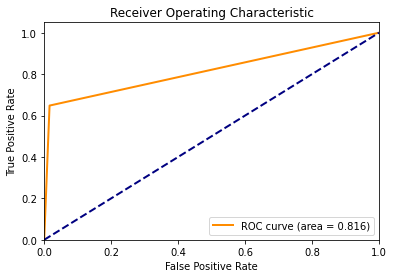

In [15]:
evaluate_model_metrics(log_reg,X_train,y_train,X_test,y_test)

### Zero Imputation

In [16]:
# Imputing with zero values

X, y, X_train, X_test, y_train, y_test = preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=SimpleImputer(strategy='constant',fill_value=0),
                                                              random_state=42)


Train Accuracy: 0.929

Test Accuracy: 0.934

Precision: 0.811

Recall: 0.597

F1-Score: 0.688

Confusion Matrix:

[[1533   30]
 [  87  129]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.95      0.98      0.96      1563
     Class 1       0.81      0.60      0.69       216

    accuracy                           0.93      1779
   macro avg       0.88      0.79      0.83      1779
weighted avg       0.93      0.93      0.93      1779


ROC-AUC Curve:


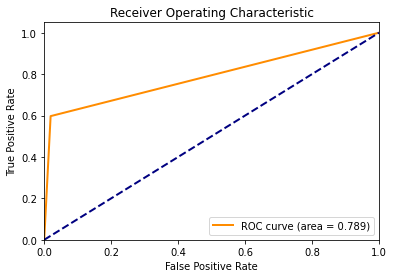

In [17]:
log_reg.fit(X_train, y_train)

evaluate_model_metrics(log_reg,X_train,y_train,X_test,y_test)

### Mode Imputation

In [18]:
# Imputing with most frequent values

X, y, X_train, X_test, y_train, y_test = preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=SimpleImputer(strategy='most_frequent'),
                                                              random_state=42)


Train Accuracy: 0.936

Test Accuracy: 0.939

Precision: 0.818

Recall: 0.644

F1-Score: 0.720

Confusion Matrix:

[[1532   31]
 [  77  139]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.95      0.98      0.97      1563
     Class 1       0.82      0.64      0.72       216

    accuracy                           0.94      1779
   macro avg       0.88      0.81      0.84      1779
weighted avg       0.94      0.94      0.94      1779


ROC-AUC Curve:


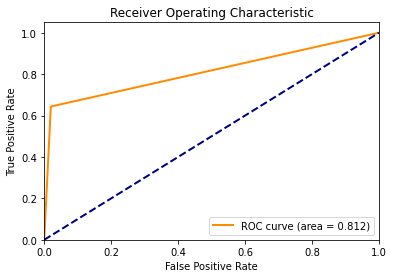

In [19]:
log_reg.fit(X_train, y_train)

evaluate_model_metrics(log_reg,X_train,y_train,X_test,y_test)

### k-NN Imputation

In [20]:
# impute missing values with values from the k-nearest neighbors in the feature space

X, y, X_train, X_test, y_train, y_test = preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=KNNImputer(n_neighbors=20),
                                                              random_state=42)


Train Accuracy: 0.934

Test Accuracy: 0.933

Precision: 0.779

Recall: 0.620

F1-Score: 0.691

Confusion Matrix:

[[1525   38]
 [  82  134]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.95      0.98      0.96      1563
     Class 1       0.78      0.62      0.69       216

    accuracy                           0.93      1779
   macro avg       0.86      0.80      0.83      1779
weighted avg       0.93      0.93      0.93      1779


ROC-AUC Curve:


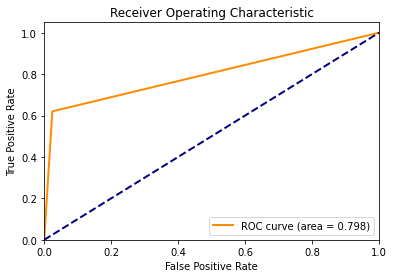

In [21]:
log_reg.fit(X_train, y_train)

evaluate_model_metrics(log_reg,X_train,y_train,X_test,y_test)

### Multiple Imputation by Chained Equations (MICE)

In [22]:
# impute by looking at data from other columns and trying to estimate the best prediction for each missing value.

from fancyimpute import IterativeImputer

X, y, X_train, X_test, y_train, y_test = preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=IterativeImputer(max_iter=20),
                                                              random_state=42)


Train Accuracy: 0.932

Test Accuracy: 0.931

Precision: 0.789

Recall: 0.588

F1-Score: 0.674

Confusion Matrix:

[[1529   34]
 [  89  127]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.94      0.98      0.96      1563
     Class 1       0.79      0.59      0.67       216

    accuracy                           0.93      1779
   macro avg       0.87      0.78      0.82      1779
weighted avg       0.93      0.93      0.93      1779


ROC-AUC Curve:


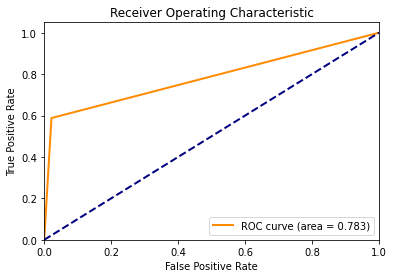

In [23]:
log_reg.fit(X_train, y_train)

evaluate_model_metrics(log_reg,X_train,y_train,X_test,y_test)

### Median Imputation

In [24]:
# Imputing with median values

X, y, X_train, X_test, y_train, y_test = preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=SimpleImputer(strategy='median'),
                                                              random_state=42)


Train Accuracy: 0.936

Test Accuracy: 0.940

Precision: 0.815

Recall: 0.653

F1-Score: 0.725

Confusion Matrix:

[[1531   32]
 [  75  141]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.95      0.98      0.97      1563
     Class 1       0.82      0.65      0.72       216

    accuracy                           0.94      1779
   macro avg       0.88      0.82      0.85      1779
weighted avg       0.94      0.94      0.94      1779


ROC-AUC Curve:


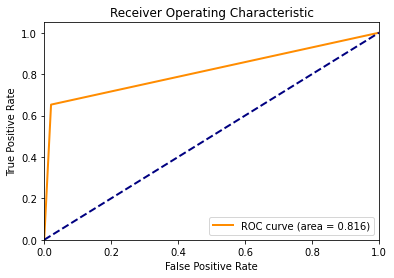

In [25]:
log_reg.fit(X_train, y_train)

evaluate_model_metrics(log_reg,X_train,y_train,X_test,y_test)

# Median values seem to perform better than mean value imputation

## Hyperparameter Optimization

In [26]:
# It is the process of finding the right combination of hyperparameter values 
# to achieve maximum performance on the data in a reasonable amount of time

### Grid Search

In [27]:
# Grid search is an exhaustive method to find optimal values for hyperparameters

# Hyperparameters
param_grid = {
    
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg','saga','lbfgs'],
    'max_iter': [100,200,300],
    'class_weight': [None, 'balanced'],
    'warm_start': [False, True],
    
}

In [28]:
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', verbose=0, n_jobs=-1)
grid_search.fit(X_train, y_train)

clear_output()     # to clear warnings

In [29]:
# Best hyperparameters
grid_best_params = grid_search.best_params_
grid_best_params

{'C': 0.1,
 'class_weight': None,
 'max_iter': 100,
 'penalty': 'l1',
 'solver': 'saga',
 'warm_start': False}

In [30]:
# Model with the best hyperparameters
log_reg_grid = grid_search.best_estimator_


Train Accuracy: 0.936

Test Accuracy: 0.943

Precision: 0.848

Recall: 0.648

F1-Score: 0.735

Confusion Matrix:

[[1538   25]
 [  76  140]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.95      0.98      0.97      1563
     Class 1       0.85      0.65      0.73       216

    accuracy                           0.94      1779
   macro avg       0.90      0.82      0.85      1779
weighted avg       0.94      0.94      0.94      1779


ROC-AUC Curve:


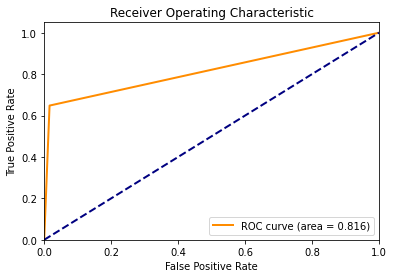

In [31]:
evaluate_model_metrics(log_reg_grid,X_train,y_train,X_test,y_test)

# We can see a slight improvement in some evaluation metrics

In [32]:
# Function to perform grid search optimisation

def grid_search_optimize(model, param_grid, cv, X_train, y_train, 
                         scoring='accuracy', verbose=0, n_jobs=-1):
    
    grid_search = GridSearchCV(model, param_grid=param_grid, cv=cv, 
                               scoring=scoring, verbose=verbose, n_jobs=n_jobs)
    
    grid_search.fit(X_train, y_train)
    clear_output()
    
    grid_best_params = grid_search.best_params_
    grid_best_model = grid_search.best_estimator_
    
    return grid_best_params, grid_best_model

### Random Search

In [33]:
# Random Search is faster than grid search due to less iterations performed but it may not be optimal 

random_search = RandomizedSearchCV(
        log_reg,
        param_distributions=param_grid,
        n_iter=100, 
        scoring='accuracy', 
        cv=5, 
        n_jobs=-1, 
        verbose=0
    )

random_search.fit(X_train, y_train)

clear_output()

In [34]:
rand_best_params = random_search.best_params_
rand_best_params

# We get similar hyperparameters

{'warm_start': False,
 'solver': 'saga',
 'penalty': 'l1',
 'max_iter': 100,
 'class_weight': None,
 'C': 0.1}

In [35]:
# Function for Random Search

def random_search_optimize(model,param,n_iter,cv,X_train, y_train,
                           scoring='accuracy', n_jobs=-1, verbose=0):
    
    random_search = RandomizedSearchCV(
        model,
        param_distributions=param,
        n_iter=n_iter, 
        scoring=scoring, 
        cv=cv, 
        n_jobs=n_jobs, 
        verbose=verbose
    )

    random_search.fit(X_train, y_train)
    clear_output()

    rand_best_params = random_search.best_params_
    rand_best_model = random_search.best_estimator_
    
    return rand_best_params, rand_best_model

In [36]:
rand_best_params, log_reg_rand = random_search_optimize(log_reg,param_grid,100,5,X_train, y_train,
                                                            scoring='accuracy', n_jobs=-1, verbose=0)


Train Accuracy: 0.936

Test Accuracy: 0.940

Precision: 0.819

Recall: 0.648

F1-Score: 0.724

Confusion Matrix:

[[1532   31]
 [  76  140]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.95      0.98      0.97      1563
     Class 1       0.82      0.65      0.72       216

    accuracy                           0.94      1779
   macro avg       0.89      0.81      0.84      1779
weighted avg       0.94      0.94      0.94      1779


ROC-AUC Curve:


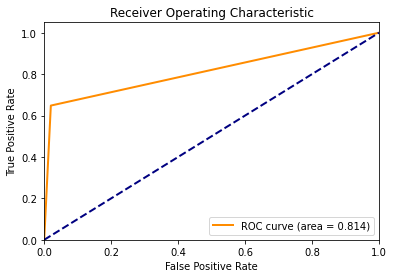

In [37]:
evaluate_model_metrics(log_reg_rand,X_train,y_train,X_test,y_test)

### OPTUNA

In [56]:
# Optuna is an automatic hyperparameter optimization software framework

def objective(trial):
    X, y, X_train, X_test, y_train, y_test = preprocess_and_split(df = diabetes_df, label = 'Diabetes',
                                                              impute = True, scale=True,
                                                              imputer=SimpleImputer(strategy='median'),
                                                              random_state=42)

    # Hyperparameter search space
    penalty = trial.suggest_categorical('penalty', ['none', 'l2'])
    C = trial.suggest_loguniform('C', 1e-5, 1e5)
    solver = trial.suggest_categorical('solver', ['newton-cg', 'saga', 'lbfgs'])
    max_iter = trial.suggest_int('max_iter', 100, 300)
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    warm_start = trial.suggest_categorical('warm_start', [False, True])

    model = LogisticRegression(
        penalty=penalty, C=C, solver=solver, max_iter=max_iter,
        class_weight=class_weight, warm_start=warm_start
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

study = optuna.create_study(direction='maximize')  # 'maximize' for accuracy, 'minimize' for loss
study.optimize(objective, n_trials=100, n_jobs=-1)
clear_output()

In [57]:
# Best optuna paramaters
best_trial = study.best_trial
print(best_trial.params)

{'penalty': 'l2', 'C': 20906.927378043856, 'solver': 'newton-cg', 'max_iter': 276, 'class_weight': None, 'warm_start': False}


In [60]:
log_reg_opt = LogisticRegression(**best_trial.params)


Train Accuracy: 0.936

Test Accuracy: 0.942

Precision: 0.826

Recall: 0.657

F1-Score: 0.732

Confusion Matrix:

[[1533   30]
 [  74  142]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.95      0.98      0.97      1563
     Class 1       0.83      0.66      0.73       216

    accuracy                           0.94      1779
   macro avg       0.89      0.82      0.85      1779
weighted avg       0.94      0.94      0.94      1779


ROC-AUC Curve:


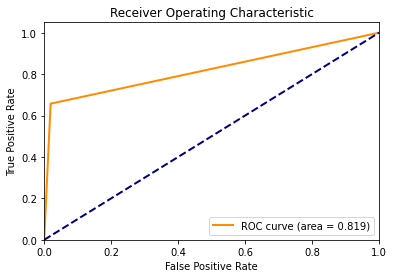

In [62]:
log_reg_opt.fit(X_train,y_train)

evaluate_model_metrics(log_reg_opt,X_train,y_train,X_test,y_test)

## Cross Validation

In [45]:
# It is a technique used to evaluate the performance of a model on unseen data.
# It involves dividing the available data into multiple folds or subsets, 
# using one of these folds as a validation set, and training the model on the remaining folds.

### K-fold

In [46]:
# The dataset is divided into k subsets or folds. 
# The model is trained and evaluated k times, using a different fold as the validation set each time. 
# Performance metrics from each fold are averaged to estimate the model's generalization performance.

scores = cross_val_score(log_reg_grid, X, y, cv=10, scoring='accuracy')

print("Scores:", scores)

Scores: [0.93932584 0.93595506 0.9494382  0.9336333  0.92688414 0.94038245
 0.94150731 0.94263217 0.92013498 0.93475816]


In [47]:
mean_accuracy = scores.mean()
std_accuracy = scores.std()

print("\nMean Accuracy: ", mean_accuracy)
print("\nStandard Deviation: ", std_accuracy)


Mean Accuracy:  0.9364651609560042

Standard Deviation:  0.007905365155841901


In [80]:
def k_cross_validate(model,X,y,cv,scoring='accuracy',n_jobs=-1):
    
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    
    mean_score = scores.mean()
    std_score = scores.std()
    
    print(f"\n{scoring} scores:", scores)
    print(f"\nMean {scoring} score: ", mean_score)
    print("\nStandard deviation: ", std_score)

In [49]:
k_cross_validate(log_reg,X,y,cv=10,scoring='accuracy',n_jobs=-1)


accuracy scores: [0.93707865 0.93258427 0.94606742 0.93250844 0.928009   0.93475816
 0.94600675 0.94038245 0.9167604  0.928009  ]

Mean accuracy score:  0.9342164532804187

Standard deviation:  0.008445836250674627


In [50]:
k_cross_validate(log_reg_grid,X,y,cv=10,scoring='accuracy',n_jobs=-1)


accuracy scores: [0.93932584 0.93595506 0.9494382  0.9336333  0.92688414 0.94038245
 0.94150731 0.94263217 0.92013498 0.93475816]

Mean accuracy score:  0.9364651609560042

Standard deviation:  0.007905365155841901


In [81]:
k_cross_validate(log_reg_opt,X,y,cv=10,scoring='accuracy',n_jobs=-1)


accuracy scores: [0.93932584 0.93820225 0.93820225 0.9336333  0.92913386 0.93475816
 0.94038245 0.94375703 0.91788526 0.9336333 ]

Mean accuracy score:  0.9348913689159641

Standard deviation:  0.006898406333979292


### Stratified K-fold

In [82]:
# Stratified k-fold ensures that each fold maintains the same class distribution as the entire dataset.
# It's useful when dealing with imbalanced datasets, where one class significantly outnumbers the other.

In [83]:
def stratified_k_cross_validate(model,X,y,n_splits,shuffle=True,random_state=42):
    
    X = X.values
    y = y.values

    stratified_kf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

    scores = []

    # Stratified k-fold cross-validation
    for train_index, test_index in stratified_kf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        confusion = confusion_matrix(y_test, y_pred)

        scores.append([accuracy,precision,recall,f1,confusion])

        average_accuracy = np.mean([item[0] for item in scores])
        average_precision = np.mean([item[1] for item in scores])
        average_recall = np.mean([item[2] for item in scores])
        average_f1 = np.mean([item[3] for item in scores])

    for fold, score in enumerate(scores, 1):
        print(f"Fold {fold}: ")
        print(f"Accuracy: {score[0]:.3f}")
#         print(f"Precision: {score[1]:.3f}")
#         print(f"Recall: {score[2]:.3f}")
#         print(f"F1-Score: {score[3]:.3f}")
#         print(f"Confusion Matrix:\n {score[4]}")
#         print('\n')

    print(f"\nAverage Accuracy: {average_accuracy:.3f}")
    print(f"Average Precision: {average_precision:.3f}")
    print(f"Average Recall: {average_recall:.3f}")
    print(f"Average F1-Score: {average_f1:.3f}")

In [84]:
stratified_k_cross_validate(log_reg,X,y,n_splits=10)

Fold 1: 
Accuracy: 0.922
Fold 2: 
Accuracy: 0.929
Fold 3: 
Accuracy: 0.943
Fold 4: 
Accuracy: 0.948
Fold 5: 
Accuracy: 0.943
Fold 6: 
Accuracy: 0.937
Fold 7: 
Accuracy: 0.927
Fold 8: 
Accuracy: 0.925
Fold 9: 
Accuracy: 0.936
Fold 10: 
Accuracy: 0.929

Average Accuracy: 0.934
Average Precision: 0.849
Average Recall: 0.605
Average F1-Score: 0.706


In [85]:
stratified_k_cross_validate(log_reg_grid,X,y,n_splits=10)

Fold 1: 
Accuracy: 0.927
Fold 2: 
Accuracy: 0.930
Fold 3: 
Accuracy: 0.942
Fold 4: 
Accuracy: 0.949
Fold 5: 
Accuracy: 0.945
Fold 6: 
Accuracy: 0.938
Fold 7: 
Accuracy: 0.929
Fold 8: 
Accuracy: 0.931
Fold 9: 
Accuracy: 0.942
Fold 10: 
Accuracy: 0.931

Average Accuracy: 0.936
Average Precision: 0.875
Average Recall: 0.604
Average F1-Score: 0.713


In [86]:
stratified_k_cross_validate(log_reg_opt,X,y,n_splits=10)

Fold 1: 
Accuracy: 0.926
Fold 2: 
Accuracy: 0.922
Fold 3: 
Accuracy: 0.946
Fold 4: 
Accuracy: 0.947
Fold 5: 
Accuracy: 0.942
Fold 6: 
Accuracy: 0.940
Fold 7: 
Accuracy: 0.927
Fold 8: 
Accuracy: 0.933
Fold 9: 
Accuracy: 0.943
Fold 10: 
Accuracy: 0.931

Average Accuracy: 0.936
Average Precision: 0.890
Average Recall: 0.583
Average F1-Score: 0.704


## Feature Selection

In [55]:
# Using all the features to train the model may result in overfitting
# This can be avoided by performing feature extraction
# We can use a combination of various methods along with domain knowledge to select the features
# Most of the insights derived from these methods and models seem to be in agreement with current research

### Correlation Analysis

In [56]:
# Function to check which features are more correlated with the disease

def get_correlated_features(df,disease,pos,neg):
    
    corr_df = df.corr()[disease].sort_values(ascending=False)
    pos_corr = corr_df[corr_df>pos]
    neg_corr = corr_df[corr_df<neg]
    
    return pos_corr, neg_corr

In [57]:
pos_corr, neg_corr = get_correlated_features(diabetes_df,'Diabetes',pos=0.1,neg=-0.1)

print('Positive Correlation\n\n',pos_corr,sep='')
print('\n\nNegative Correlation\n\n',neg_corr,sep='')

Positive Correlation

Diabetes                              1.000000
Glycohemoglobin [%]                   0.616415
Fasting Glucose [mmol/L]              0.610611
Age                                   0.396039
BMI                                   0.269706
Blood Urea Nitrogen [mg/dL]           0.242561
Insulin [pmol/L]                      0.234273
Osmolality [mmol/Kg]                  0.224238
Retinol [umol/L]                      0.213473
Triglyceride [mmol/L]                 0.167136
Alpha-tocopherol [umol/L]             0.162476
Triglyceride_HDL Ratio                0.156951
Segmented neutrophils [%]             0.153802
Neutrophil_Lymphocyte Ratio           0.147970
C-Reactive Protein [mg/L]             0.137446
Creatinine [mg/dL]                    0.132612
Ferritin [ng/mL]                      0.130874
Red cell distribution width [%]       0.124067
25-hydroxyvitamin D2 + D3 [nmol/L]    0.104823
Total Cholestrol_HDL Ratio            0.104507
Mean platelet volume [fL]             

### Select From Model

In [58]:
# SelectFromModel can be used with any estimator that exposes feature importance

def select_from_model_features(model,X,y):

    sfm = SelectFromModel(model)  

    
    sfm.fit_transform(X, y)

    
    selected_features = sfm.get_support()
    feature_names = X.columns
    sfm_features = [feature_names[i] for i, selected in enumerate(selected_features) if selected]

    return sfm_features

In [59]:
sfm_features = select_from_model_features(log_reg,X,y)
sfm_features

['Age',
 'BMI',
 'Eosinophils [%]',
 'Fasting Glucose [mmol/L]',
 'Glycohemoglobin [%]',
 'Hematocrit [%]',
 'Lymphocyte [%]',
 'Mean Cell Hgb Conc. [g/dL]',
 'Mean cell hemoglobin [pg]',
 'Mean cell volume [fL]',
 'Monocyte [%]',
 'Non_HDL Ratio',
 'RBC count [million cells/uL]',
 'Retinol [umol/L]',
 'Segmented neutrophils [%]',
 'Total Cholesterol [mmol/L]',
 'Total Iron Binding Capacity [umol/L]',
 'UIBC [umol/L]',
 'Alkaline Phosphatase [IU/L]',
 'Direct HDL-Cholesterol [mmol/L]',
 'Hemoglobin [g/dL]',
 'Transferrin Saturation [%]']

### SelectKBest

In [60]:
# Function to select features using SelectKBest using anova scores

def select_k_best(X,y,n):
    
    select = SelectKBest(score_func = f_classif, k = n)
    
    z = select.fit_transform(X,y)

    feature_rankings = select.scores_
    feature_rankings_df = pd.DataFrame({'Feature': X.columns, 'Ranking': feature_rankings})
    sorted_features = feature_rankings_df.sort_values(by='Ranking',ascending=False)
    
    return sorted_features.Feature.head(n).values

In [61]:
k_best_features = select_k_best(X, y, n=30)
k_best_features

array(['Glycohemoglobin [%]', 'Fasting Glucose [mmol/L]', 'Age', 'BMI',
       'Blood Urea Nitrogen [mg/dL]', 'Retinol [umol/L]',
       'Osmolality [mmol/Kg]', 'Insulin [pmol/L]',
       'Alpha-tocopherol [umol/L]', 'Lymphocyte [%]',
       'Neutrophil_Lymphocyte Ratio', 'Ferritin [ng/mL]',
       'Segmented neutrophils [%]', 'Albumin [g/dL]',
       'C-Reactive Protein [mg/L]', 'Creatinine [mg/dL]',
       'Triglyceride [mmol/L]', 'Lymphocyte_C-Reactive Protein Ratio',
       'Triglyceride_HDL Ratio', 'Red cell distribution width [%]',
       'Platelet_WBC Ratio', 'Alpha-crypotoxanthin [umol/L]',
       'Direct HDL-Cholesterol [mmol/L]', 'Chloride [mmol/L]',
       'Total Cholestrol_HDL Ratio', 'Gamma Glutamyl Transferase [IU/L]',
       'Gamma-tocopherol [umol/L]', 'A/G Ratio',
       'Platelet count [1000 cells/uL]',
       '25-hydroxyvitamin D2 + D3 [nmol/L]'], dtype=object)

### Recursive Feature Elimination (RFE) 

In [62]:
#  RFE is a method that recursively removes the least important features from the dataset

def select_rfe_features(model,X,y,n,step):
    
    rfe = RFE(model,n_features_to_select=n,step=step)
    fit = rfe.fit(X, y)

    feature_rankings = rfe.ranking_
    feature_rankings_df = pd.DataFrame({'Feature': X.columns, 'Ranking': feature_rankings})
    sorted_features = feature_rankings_df.sort_values(by='Ranking')
    
    return sorted_features.Feature.head(n).values

In [63]:
rfe_features = select_rfe_features(log_reg,X,y,n=30,step=0.2)
rfe_features

array(['Gender', 'Mean cell hemoglobin [pg]', 'Mean cell volume [fL]',
       'Iron [ug/dL]', 'Monocyte [%]', 'Hematocrit [%]',
       'Glycohemoglobin [%]', 'Non_HDL Ratio',
       'Transferrin receptor [nmol/L]', 'Fasting Glucose [mmol/L]',
       'Eosinophils [%]', 'RBC count [million cells/uL]',
       'Retinol [umol/L]', 'Segmented neutrophils [%]',
       'Mean Cell Hgb Conc. [g/dL]', 'Total Cholesterol [mmol/L]',
       'UIBC [umol/L]', 'Transferrin Saturation [%]', 'Age', 'BMI',
       'Hemoglobin [g/dL]', 'Direct HDL-Cholesterol [mmol/L]',
       'Total Iron Binding Capacity [umol/L]',
       'Alkaline Phosphatase [IU/L]',
       'White blood cell count [1000 cells/uL]', 'Vitamin C [umol/L]',
       'Uric Acid [mg/dL]', 'Blood lead [umol/L]', 'Albumin [g/dL]',
       'Lymphocyte [%]'], dtype=object)

### Recursive Feature Addition (RFA)

In [64]:
# It starts with an empty feature set and iteratively adds one feature at a time based on its performance.

def rfa_feature_select(model,X,y,n,cv,step,scoring='accuracy',n_jobs=-1):

    rfecv = RFECV(model, step=step, cv=StratifiedKFold(cv), scoring=scoring, n_jobs=n_jobs)
    rfecv.fit(X, y)
    clear_output()
    
    feature_rankings = rfecv.ranking_
    feature_rankings_df = pd.DataFrame({'Feature': X.columns, 'Ranking': feature_rankings})
    sorted_features = feature_rankings_df.sort_values(by='Ranking')
    
    return sorted_features.Feature.head(n).values

In [65]:
rfa_features = rfa_feature_select(log_reg,X,y,n=30,cv=10,step=0.3,scoring='accuracy')
rfa_features

array(['White blood cell count [1000 cells/uL]', 'Uric Acid [mg/dL]',
       'UIBC [umol/L]', 'Eosinophils [%]', 'Fasting Glucose [mmol/L]',
       'RBC count [million cells/uL]', 'Glycohemoglobin [%]',
       'Hematocrit [%]', 'Monocyte [%]', 'Iron [ug/dL]',
       'Total Lycopene [umol/L]', 'Total Iron Binding Capacity [umol/L]',
       'Segmented neutrophils [%]', 'Lymphocyte [%]',
       'Total Cholesterol [mmol/L]', 'Mean cell volume [fL]',
       'Vitamin C [umol/L]', 'Mean Cell Hgb Conc. [g/dL]',
       'Mean cell hemoglobin [pg]', 'Alkaline Phosphatase [IU/L]',
       'Transferrin Saturation [%]', 'Age', 'BMI',
       'Platelet count [1000 cells/uL]', 'A/G Ratio',
       'LDL-Cholesterol(NIH2) [mmol/L]', 'Insulin [pmol/L]',
       'Albumin [g/dL]', 'Hemoglobin [g/dL]',
       'Direct HDL-Cholesterol [mmol/L]'], dtype=object)

### Lasso Regularization

In [66]:
# Uses lasso regularization to give more weights to more important features

l1_reg_model = LogisticRegression(penalty='l1', solver='saga')
l1_reg_model.fit(X_train, y_train)

# Get feature importance coefficients from the model
feature_importance = l1_reg_model.coef_[0]

feature_importance_pairs = [(feature, importance) for feature, importance in zip(X.columns, feature_importance)]
feature_importance_pairs.sort(key=lambda x: abs(x[1]), reverse=True)

l1_sorted_features = [feature for feature, _ in feature_importance_pairs]
print("L1 Selected Features:\n\n", l1_sorted_features[:30])

L1 Selected Features:

 ['Glycohemoglobin [%]', 'Fasting Glucose [mmol/L]', 'Age', 'Gender', 'BMI', 'Osmolality [mmol/Kg]', 'Alkaline Phosphatase [IU/L]', 'Non_HDL Ratio', 'Total Cholesterol [mmol/L]', 'Retinol [umol/L]', 'Mean Cell Hgb Conc. [g/dL]', 'Blood lead [umol/L]', 'Gamma Glutamyl Transferase [IU/L]', 'Transferrin Saturation [%]', 'Vitamin C [umol/L]', 'Insulin [pmol/L]', 'Transferrin receptor [nmol/L]', 'LDL-Cholesterol(NIH2) [mmol/L]', 'Direct HDL-Cholesterol [mmol/L]', 'Sodium [mmol/L]', 'Aspartate Aminotransferase [U/L]', 'Creatinine [mg/dL]', 'Creatine Phosphokinase [IU/L]', 'Uric Acid [mg/dL]', 'Chloride [mmol/L]', 'Albumin [g/dL]', 'Lactate Dehydrogenase [IU/L]', 'Bicarbonate [mmol/L]', 'Blood selenium [umol/L]', 'Alpha-carotene [umol/L]']


In [67]:
# We make a final list of features combining the above methods and domain knowledge

final_selected_features = ['Age','BMI','Glycohemoglobin [%]', 'Fasting Glucose [mmol/L]', 
                  'Blood Urea Nitrogen [mg/dL]', 'Insulin [pmol/L]','Osmolality [mmol/Kg]',
                  'Retinol [umol/L]','Neutrophil_Lymphocyte Ratio','C-Reactive Protein [mg/L]',
                  'Albumin [g/dL]', 'Lymphocyte [%]','Alpha-crypotoxanthin [umol/L]',
                  'Direct HDL-Cholesterol [mmol/L]', 'Alkaline Phosphatase [IU/L]','Gender',
                  'Hemoglobin [g/dL]','Alanine Aminotransferase [U/L]','Aspartate Aminotransferase [U/L]',
                  'Creatinine [mg/dL]','Total Protein [g/dL]','Uric Acid [mg/dL]',
                  'RBC count [million cells/uL]','White blood cell count [1000 cells/uL]',
                  'Hematocrit [%]','Mean Cell Hgb Conc. [g/dL]','Red cell distribution width [%]']

In [68]:
# Split the data and train model

new_diabetes_df = diabetes_df[final_selected_features+['Diabetes']]

X, y, X_train, X_test, y_train, y_test = preprocess_and_split(df = new_diabetes_df, label = 'Diabetes',
                                                              impute = True, 
                                                              imputer=SimpleImputer(strategy='median'),
                                                              random_state=42)


Train Accuracy: 0.934

Test Accuracy: 0.942

Precision: 0.842

Recall: 0.644

F1-Score: 0.730

Confusion Matrix:

[[1537   26]
 [  77  139]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.95      0.98      0.97      1563
     Class 1       0.84      0.64      0.73       216

    accuracy                           0.94      1779
   macro avg       0.90      0.81      0.85      1779
weighted avg       0.94      0.94      0.94      1779


ROC-AUC Curve:


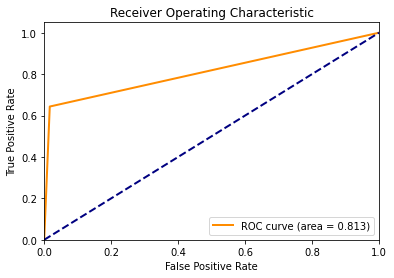

In [69]:
log_reg2 = LogisticRegression()

log_reg2.fit(X_train, y_train)

evaluate_model_metrics(log_reg2,X_train,y_train,X_test,y_test)

In [70]:
# We observe slightly better scores using only a few features, due to lesser overfitting

# Grid Search Optimisation
params, log_reg2_grid = grid_search_optimize(log_reg2,param_grid,cv=10,X_train=X_train,y_train=y_train)

In [71]:
params

{'C': 0.1,
 'class_weight': None,
 'max_iter': 100,
 'penalty': 'l2',
 'solver': 'saga',
 'warm_start': False}


Train Accuracy: 0.935

Test Accuracy: 0.943

Precision: 0.852

Recall: 0.639

F1-Score: 0.730

Confusion Matrix:

[[1539   24]
 [  78  138]]


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.95      0.98      0.97      1563
     Class 1       0.85      0.64      0.73       216

    accuracy                           0.94      1779
   macro avg       0.90      0.81      0.85      1779
weighted avg       0.94      0.94      0.94      1779


ROC-AUC Curve:


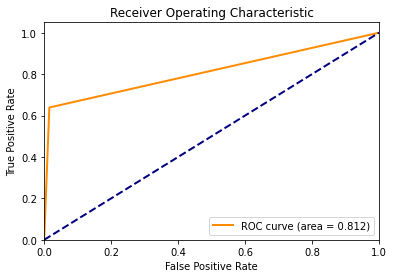

In [72]:
log_reg2_grid.fit(X_train, y_train)

evaluate_model_metrics(log_reg2_grid,X_train,y_train,X_test,y_test)

In [73]:
# We see that the tuned model performs slightly better
# Now to evaluate further, we use cross validation

k_cross_validate(log_reg2,X,y,cv=10,scoring='accuracy')


accuracy scores: [0.94269663 0.93595506 0.93932584 0.928009   0.92125984 0.93588301
 0.94488189 0.94825647 0.91338583 0.93250844]

Mean accuracy score:  0.934216200503027

Standard deviation:  0.010285579867432037


In [74]:
k_cross_validate(log_reg2_grid,X,y,cv=10,scoring='accuracy')


accuracy scores: [0.94606742 0.93483146 0.94157303 0.92688414 0.9223847  0.93925759
 0.94375703 0.95050619 0.9167604  0.93475816]

Mean accuracy score:  0.9356780121585926

Standard deviation:  0.010267096094669139


In [75]:
stratified_k_cross_validate(log_reg2,X,y,n_splits=10,random_state=42)

Fold 1: 
Accuracy: 0.920
Fold 2: 
Accuracy: 0.920
Fold 3: 
Accuracy: 0.943
Fold 4: 
Accuracy: 0.942
Fold 5: 
Accuracy: 0.947
Fold 6: 
Accuracy: 0.939
Fold 7: 
Accuracy: 0.927
Fold 8: 
Accuracy: 0.929
Fold 9: 
Accuracy: 0.935
Fold 10: 
Accuracy: 0.930

Average Accuracy: 0.933
Average Precision: 0.852
Average Recall: 0.596
Average F1-Score: 0.701


In [76]:
stratified_k_cross_validate(log_reg2_grid,X,y,n_splits=10,random_state=42)

Fold 1: 
Accuracy: 0.922
Fold 2: 
Accuracy: 0.926
Fold 3: 
Accuracy: 0.945
Fold 4: 
Accuracy: 0.942
Fold 5: 
Accuracy: 0.948
Fold 6: 
Accuracy: 0.940
Fold 7: 
Accuracy: 0.928
Fold 8: 
Accuracy: 0.933
Fold 9: 
Accuracy: 0.937
Fold 10: 
Accuracy: 0.934

Average Accuracy: 0.935
Average Precision: 0.878
Average Recall: 0.593
Average F1-Score: 0.707
